In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import tensorflow as tf
from tensorflow import keras
import random
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import BatchNormalization
from sklearn import preprocessing
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, \
    Permute, TimeDistributed, Bidirectional, GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from keras.applications.vgg16 import VGG16

In [2]:
metadata_file = "C:/Extra project/Skin Cancer/HAM10000_metadata.csv"
cancer = pd.read_csv(metadata_file)

In [3]:
cancer["path"] = ""
image_paths = []
for part in ("part_1", "part_2"):
    image_paths += glob.glob("C:/Extra project/Skin Cancer/HAM10000_images_" + part + "/*")
image_ids_n_paths = {os.path.splitext(os.path.basename(path))[0]: path for path in image_paths}
cancer['path'] = cancer['image_id'].map(image_ids_n_paths)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
for layer in vgg16.layers:
    layer.trainable = False

In [5]:
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Update the number of units to match the number of classes in your dataset

In [6]:
model = Model(inputs=vgg16.input, outputs=predictions)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [7]:
train_data, test_val_data = train_test_split(cancer, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col="path",
    y_col="dx",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

test_val_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_val_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col="path",
    y_col="dx",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

val_generator = test_val_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col="path",
    y_col="dx",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


In [9]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
             tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy", save_best_only=True, filepath="./my_model") ]

In [12]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
220/220 [==============================] - 1280s 6s/step - loss: 1.1539 - accuracy: 0.6609 - val_loss: 0.9262 - val_accuracy: 0.6873
Epoch 2/10
220/220 [==============================] - 1522s 7s/step - loss: 1.0004 - accuracy: 0.6748 - val_loss: 0.8879 - val_accuracy: 0.6780
Epoch 3/10
220/220 [==============================] - 1411s 6s/step - loss: 0.9439 - accuracy: 0.6740 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 4/10
220/220 [==============================] - 1262s 6s/step - loss: 0.9493 - accuracy: 0.6796 - val_loss: 0.8727 - val_accuracy: 0.6640
Epoch 5/10
220/220 [==============================] - 1468s 7s/step - loss: 0.9245 - accuracy: 0.6775 - val_loss: 0.8417 - val_accuracy: 0.6753
Epoch 6/10
220/220 [==============================] - 1499s 7s/step - loss: 0.9091 - accuracy: 0.6860 - val_loss: 0.8438 - val_accuracy: 0.6786
Epoch 7/10
220/220 [==============================] - 1705s 8s/step - loss: 0.8906 - accuracy: 0.6852 - val_loss: 0.8513 - val_accuracy:

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

47/47 [==============================] - 340s 7s/step - loss: 0.8182 - accuracy: 0.6931
Test Loss: 0.8182117938995361
Test Accuracy: 0.6930758953094482


<AxesSubplot:>

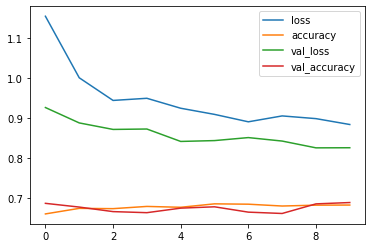

In [14]:
plot_VGG16 = pd.DataFrame(history.history)
plot_VGG16.plot()